In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
import matplotlib.pyplot as plt
import pandas
import math

In [4]:
import csv
import glob

In [5]:
# Theano loaded using : conda install m2w64-toolchain

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#import pandas_datareader.data as pdr_data
import numpy as np
import pandas as pd
import time
import os
import sys
from collections import deque
from collections import OrderedDict
import copy
#import cPickle as pkl
import random
import pdb
import logging

import theano
#import theano.tensor as tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.ifelse import ifelse
from theano import config

import tensorflow as tf
#import config as c
#from tensorflow.models.rnn import rnn
#from tensorflow.models.rnn import rnn_cell
#from tensorflow.models.rnn import seq2seq

import time
import warnings
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense,LSTM
#from keras.layers import LSTM
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [6]:
# loading csv file
def get_csv_pd(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd=pd.read_csv(path,sep=',',dtype={'askPrice':np.float32,'askSize':np.float32,
                                           'bidPrice':np.float32,'bidSize':np.float32},index_col=0,parse_dates=True)
    #spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd

def BA(df):
    df.bidPrice=df.loc[:,'bidPrice'].replace(to_replace=0, method='ffill')
    df.bidSize=df.loc[:,'bidSize'].replace(to_replace=0, method='ffill')
    df.askPrice=df.loc[:,'askPrice'].replace(to_replace=0, method='ffill')
    df.askSize=df.loc[:,'askSize'].replace(to_replace=0, method='ffill')
    df=df.dropna()
    return df

def preprocessing(df):
    df=df.dropna()
    # to exclude 0
    df=df[df['bidPrice']>df.bidPrice.mean()-df.bidPrice.std()]
    df=df[df['askPrice']>df.askPrice.mean()-df.askPrice.std()]
    df['mid']=(df.askPrice+df.bidPrice)/2
    df['vwap']=((df.loc[:,'bidPrice']*df.loc[:,'bidSize'])+(df.loc[:,'askPrice']*df.loc[:,'askSize']))/(df.loc[:,'bidSize']+df.loc[:,'askSize'])
    df['spread']=df.vwap-df.mid
    df['v']=(df.mid-df.mid.shift(60))
    df['mom']=np.where(np.logical_and((df.mid-df.mid.shift(12))!=0,df.v!=0),(df.mid-df.mid.shift(12))/df.v,0)
    df['return']=(df.askPrice/df.bidPrice.shift(1))-1
    #df['ret'] = np.log(df.Close/df.Close.shift(1))
    df['sigma']=df.spread.rolling(60).std()
    #df['sigma']=df.Close.rolling(5).std()
    df['high']=df.askPrice.rolling(5).max()
    df['low']=df.bidPrice.rolling(5).min()
    
    #df['mom']=np.where(np.logical_and(df.vel_c==1,df.Close>df.price),1,np.where(np.logical_and(df.vel_c==-1,df.Close<df.price),-1,0))
    #flagD=np.logical_and(np.logical_and(df.Close.shift(10)<df.Close.shift(15),df.Close.shift(15)< df.Close.shift(20)),df.Close< df.Close.shift(10))
    #flagU=np.logical_and(np.logical_and(df.Close.shift(15)>df.Close.shift(20),df.Close.shift(10)> df.Close.shift(15)),df.Close> df.Close.shift(10))
    #df['UD']= np.where(flagU,-1,np.where(flagD,1,0))
    
    #df['P']=(df.High+df.Low+df.Close)/3
    #df['UT']=(pd.rolling_max(df.High,60)+pd.rolling_max(df.P+df.High-df.Low,60))*0.5
    #df['DT']=(pd.rolling_min(df.Low,60)+pd.rolling_min(df.P+df.High-df.Low,60))*0.5
    #df['BA']=np.where(df.Close<=df.DT,-1,np.where(df.Close>=df.UT,1,0))# below or above
    return df

'''
def normalise(df,window_length=60):
    data=df[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    dfn=data/data.shift(60)
    return dfn
'''
def normalise(dfn,window_length=60):
    dfn['midN']=dfn.mid/dfn.mid.shift(60)
    dfn['vwapN']=dfn.vwap/dfn.mid.shift(60)
    #dfn['highN']=dfn.high/dfn.high.shift(60)
    #dfn['lowN']=dfn.low/dfn.low.shift(60)
    dfn['HL']=(dfn.high-dfn.low)/dfn.mid.shift(60)
    dfn=dfn[['midN','vwapN','HL','spread','v','mom','return','sigma']]
    return dfn

In [7]:
filename = '/home/octo/Dropbox'+ '/SPY18Dec.csv'

In [8]:
data=get_csv_pd(filename)

In [9]:
data.tail()

,askPrice,askSize,bidPrice,bidSize
2017-12-19 09:24:27.494064,268.380005,52.0,268.369995,132.0
2017-12-19 09:24:30.229113,268.380005,50.0,268.369995,132.0
2017-12-19 09:24:33.545713,268.380005,50.0,268.369995,152.0
2017-12-19 09:24:37.270081,268.380005,41.0,268.369995,152.0
2017-12-19 09:24:40.471072,268.380005,41.0,268.369995,157.0


In [10]:
baset=BA(data)

In [11]:
baset.tail()

,askPrice,askSize,bidPrice,bidSize
2017-12-19 09:24:27.494064,268.380005,52.0,268.369995,132.0
2017-12-19 09:24:30.229113,268.380005,50.0,268.369995,132.0
2017-12-19 09:24:33.545713,268.380005,50.0,268.369995,152.0
2017-12-19 09:24:37.270081,268.380005,41.0,268.369995,152.0
2017-12-19 09:24:40.471072,268.380005,41.0,268.369995,157.0


In [14]:
data_=preprocessing(baset)

In [15]:
data_.tail()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,spread,v,mom,return,sigma,high,low
2017-12-19 09:24:27.494064,268.380005,52.0,268.369995,132.0,268.375,268.372833,-0.002167,-0.01001,1.0,0.000037,0.002835,268.380005,268.369995
2017-12-19 09:24:30.229113,268.380005,50.0,268.369995,132.0,268.375,268.372742,-0.002258,-0.01001,0.5,0.000037,0.002810,268.380005,268.369995
2017-12-19 09:24:33.545713,268.380005,50.0,268.369995,152.0,268.375,268.372467,-0.002533,-0.01001,0.5,0.000037,0.002789,268.380005,268.369995
2017-12-19 09:24:37.270081,268.380005,41.0,268.369995,152.0,268.375,268.372131,-0.002869,-0.01001,0.0,0.000037,0.002772,268.380005,268.369995
2017-12-19 09:24:40.471072,268.380005,41.0,268.369995,157.0,268.375,268.372070,-0.002930,-0.01001,0.0,0.000037,0.002745,268.380005,268.369995


In [16]:
dfn=normalise(data_).dropna()

In [17]:
data=data_.dropna()
data=data_[['mid','vwap','spread','v','mom','return','sigma','high','low',]]

In [18]:
data.tail()

,mid,vwap,spread,v,mom,return,sigma,high,low
2017-12-19 09:24:27.494064,268.375,268.372833,-0.002167,-0.01001,1.0,0.000037,0.002835,268.380005,268.369995
2017-12-19 09:24:30.229113,268.375,268.372742,-0.002258,-0.01001,0.5,0.000037,0.002810,268.380005,268.369995
2017-12-19 09:24:33.545713,268.375,268.372467,-0.002533,-0.01001,0.5,0.000037,0.002789,268.380005,268.369995
2017-12-19 09:24:37.270081,268.375,268.372131,-0.002869,-0.01001,0.0,0.000037,0.002772,268.380005,268.369995
2017-12-19 09:24:40.471072,268.375,268.372070,-0.002930,-0.01001,0.0,0.000037,0.002745,268.380005,268.369995


In [19]:
dfn.tail()

,midN,vwapN,HL,spread,v,mom,return,sigma
2017-12-19 09:24:27.494064,0.999963,0.999955,0.000037,-0.002167,-0.01001,1.0,0.000037,0.002835
2017-12-19 09:24:30.229113,0.999963,0.999954,0.000037,-0.002258,-0.01001,0.5,0.000037,0.002810
2017-12-19 09:24:33.545713,0.999963,0.999953,0.000037,-0.002533,-0.01001,0.5,0.000037,0.002789
2017-12-19 09:24:37.270081,0.999963,0.999952,0.000037,-0.002869,-0.01001,0.0,0.000037,0.002772
2017-12-19 09:24:40.471072,0.999963,0.999952,0.000037,-0.002930,-0.01001,0.0,0.000037,0.002745


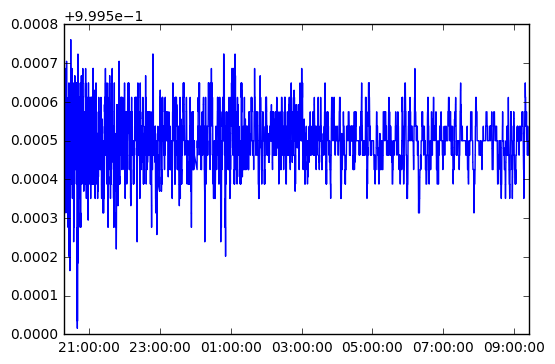

In [20]:
plt.plot(dfn.midN)
plt.show()

In [21]:
dataset = dfn.values
dataset = dataset.astype('float32')

In [22]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [23]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

30352 7588


In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        b = dataset[i:(i+look_back), 1]
        c = dataset[i:(i+look_back), 2]
        d = dataset[i:(i+look_back), 3]
        e=  dataset[i:(i+look_back), 4]
        f=  dataset[i:(i+look_back), 5]
        g=  dataset[i:(i+look_back), 6]
        h=  dataset[i:(i+look_back), 7]
               
        dataX.append(numpy.c_[b,c,d,e,f,g,h])
        #dataX.append(b)
        #dataX.append(c)
        #dataX.append(d)
        #dataX.append(e)
        #dataX.concatenate((a,bT,cT,dT,eT),axis=1)
        dataY.append(a)
    return numpy.array(dataX), numpy.array(dataY)

In [25]:
# reshape into X=t and Y=t+1
look_back =1
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)

In [26]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0],trainX.shape[1],trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0],testX.shape[1],testX.shape[2]))

In [27]:
epochs=3
batch_size=3

In [28]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(3, input_shape=(look_back,7)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs, batch_size, verbose=2)

Epoch 1/3
13s - loss: 0.0175
Epoch 2/3
13s - loss: 2.4827e-05
Epoch 3/3
12s - loss: 9.7398e-05


In [29]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [30]:
trainPredict.shape

(30350, 1)

In [31]:
trainPredict[3:]

array([[ 0.99937874],
       [ 0.99938196],
       [ 0.99937814],
       ..., 
       [ 0.99939966],
       [ 0.99940145],
       [ 0.99941647]], dtype=float32)

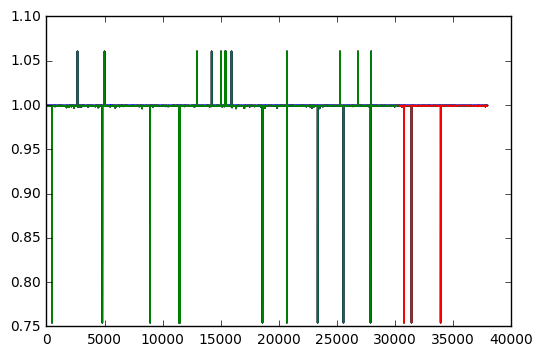

In [32]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(dataset[:,0])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [59]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

In [64]:
model = build_model([7, 50, 100, 1])

Compilation Time :  0.030323028564453125


In [65]:
model.fit(trainX,trainY,batch_size=512,nb_epoch=3,validation_split=0.05)

Train on 16951 samples, validate on 893 samples
Epoch 1/3
16951/16951 [==============================] - 2s - loss: 0.4174 - val_loss: 0.0480

In [66]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [67]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(data, label='Prediction')
        plt.legend()
    plt.show()

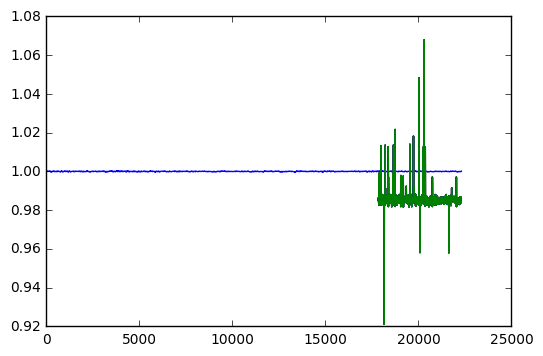

In [68]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(dataset[:,0])
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [70]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(data, label='Prediction')
        plt.legend()
    plt.show()

In [72]:
plot_results_multiple(testPredict,testY,10000)

KeyboardInterrupt: 

In [77]:
# create model
model = Sequential()
model.add(Dense(3, input_dim=7, init='uniform', activation='relu'))
model.add(Dense(3, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(trainX,trainY, nb_epoch=7, batch_size=10)
# evaluate the model
scores = model.evaluate(testX,testY)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ValueError: Error when checking model input: expected dense_input_5 to have 2 dimensions, but got array with shape (17844, 1, 7)

In [ ]:
'''
dataset =numpy.loadtxt("/home/octo/Dropbox/SPY7Dec.csv",
   dtype={'names': ('askPrice', 'askSize', 'bidPrice', 'bidSize'),
          'formats': (numpy.str,numpy.str,numpy.str,numpy.str)},
   delimiter=',', skiprows=0)
'''   